In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math 
from sklearn.linear_model import LinearRegression
import pandas as pd
import statsmodels.api as sm

In [51]:
def bootstrap(data, nboot):
    data = np.ravel(data)
    
    # index 를 여러번 뽑는다. 그래서 그 index로 조회.
    idx = np.random.randint(data.size, size = (nboot, data.size))
    return data[idx]

def getBootCi(data, stat, nboot, alpha=0.05):
    # nboot : data.size 만큼씩 몇번 뽑았냐? 이게 많아야 통계량이 많아짐.
    booted_data = bootstrap(data, nboot)
    print(booted_data.shape)
    mean_set = np.sort(stat(booted_data, axis=1))
    upper_idx = int(np.round(nboot*(1-(alpha/2))))
    lower_idx = int(np.round(nboot*(alpha/2)))
    
    print("upper_idx:",upper_idx)
    print("lower_idx:", lower_idx)
    return mean_set[upper_idx], mean_set[lower_idx]
    

In [3]:
mean = 3
std = 1
data = np.random.normal(mean, std, 1000)

(array([ 1.,  0.,  0.,  1.,  0.,  3.,  1.,  5., 23., 16., 16., 25., 28.,
        28., 41., 47., 42., 65., 51., 53., 69., 61., 47., 62., 47., 41.,
        49., 42., 30., 25., 22., 18., 15.,  9.,  8.,  3.,  2.,  1.,  1.,
         2.]),
 array([-3.23620684e-01, -1.63622788e-01, -3.62489151e-03,  1.56373005e-01,
         3.16370901e-01,  4.76368797e-01,  6.36366693e-01,  7.96364590e-01,
         9.56362486e-01,  1.11636038e+00,  1.27635828e+00,  1.43635617e+00,
         1.59635407e+00,  1.75635197e+00,  1.91634986e+00,  2.07634776e+00,
         2.23634566e+00,  2.39634355e+00,  2.55634145e+00,  2.71633934e+00,
         2.87633724e+00,  3.03633514e+00,  3.19633303e+00,  3.35633093e+00,
         3.51632883e+00,  3.67632672e+00,  3.83632462e+00,  3.99632251e+00,
         4.15632041e+00,  4.31631831e+00,  4.47631620e+00,  4.63631410e+00,
         4.79631200e+00,  4.95630989e+00,  5.11630779e+00,  5.27630568e+00,
         5.43630358e+00,  5.59630148e+00,  5.75629937e+00,  5.91629727e+00,
      

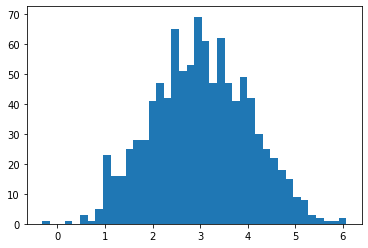

In [59]:
plt.hist(data, bins=40)

### theoretical mean Ci 5% in Normal distribution 

sample_mean = 3 , sampled_std = 1

$$
\bar{x}-1.96 \times \frac{\sigma}{\sqrt{n}} < \mu < \bar{x}+1.96 \times \frac{\sigma}{\sqrt{n}}
$$



In [60]:

sample_count = data.size
print(sample_count)
lower_bound = 3 - 1.96*(1/math.sqrt(sample_count))
upper_bound = 3 + 1.96*(1/math.sqrt(sample_count))

print("lower_bound ", lower_bound)
print("upper_bound ", upper_bound)

1000
lower_bound  2.9380193578607
upper_bound  3.0619806421393


In [61]:
upper, lower = getBootCi(data, np.mean, 50000, 0.05)
print("lower_bound ", lower)
print("upper_bound ", upper)

(50000, 1000)
upper_idx: 48750
lower_idx: 1250
lower_bound  2.9490305580017577
upper_bound  3.075428891295221


## Coefficient Estimation 

In [7]:
data_count = 50 

x1 = np.random.uniform(0, 20, data_count)
x2 = np.random.uniform(-20, 20, data_count)
y = 2+ 5*x1 - 2*x2 + np.random.normal(0, 5, data_count)


In [8]:
mlr = LinearRegression()
dataframe = pd.DataFrame({"x1":x1, "x2": x2, "y": y})

x_train = dataframe[["x1", "x2"]]
y_train = dataframe[["y"]]
# mlr.fit(x_train, y_train)
x_train = sm.add_constant(x_train)

smOLSmodel = sm.OLS(y_train, x_train).fit()


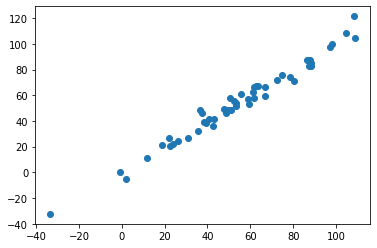

In [61]:
fitted_value = smOLSmodel.predict(x_train)
plt.scatter(fitted_value, y_train)

In [62]:
print(smOLSmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     960.3
Date:                Tue, 28 Jul 2020   Prob (F-statistic):           7.71e-39
Time:                        23:05:02   Log-Likelihood:                -147.32
No. Observations:                  50   AIC:                             300.6
Df Residuals:                      47   BIC:                             306.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2368      1.518      0.815      0.4

### bootstrap 으로 회귀계수 구하기 

In [63]:
print(smOLSmodel.params)

const    1.236843
x1       5.018907
x2      -2.036979
dtype: float64


In [10]:
def bootstrapDF(df, nboot):
    row_count = dataframe.shape[0]
    constant_list = []
    x1_list = []
    x2_list = []
    for nrounds in range(nboot):
        if nrounds%1000 ==0:
            print("nrounds: ", nrounds)
        idx = np.ravel(np.random.randint(row_count, size = row_count))
        temp_df = dataframe.iloc[idx]
        x_train = temp_df[["x1",  "x2"]]
        y_train = temp_df[["y"]]
        x_train = sm.add_constant(x_train)
        smOLSmodel = sm.OLS(y_train, x_train).fit()
        coefs = smOLSmodel.params
        constant_list.append(coefs[0])
        x1_list.append(coefs[1])
        x2_list.append(coefs[2])
    return constant_list, x1_list, x2_list    
        
    

In [11]:
const, x1, x2 = bootstrapDF(dataframe, 5000)

nrounds:  0
nrounds:  1000
nrounds:  2000
nrounds:  3000
nrounds:  4000


In [16]:
from scipy import stats

print("\n=======const estimation=====\n")
print(np.mean(const))
print(np.std(const))
print("\n=======x1 estimation=====\n")
print(np.mean(x1))
print(np.std(x1))
print("\n=======x2 estimation=====\n")
print(np.mean(x2))
print(np.std(x2))



=======const estimation=====

2.0943618601106175
1.4278319141808975

=======x1 estimation=====

5.039985350575786
0.11266699107316792

=======x2 estimation=====

-2.067339402089532
0.05525747357365559
